In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

In [2]:
url_dataset = pd.read_parquet('../data/dataset.parquet')
vec_column = url_dataset['vec']
text_column = url_dataset['contents']
url_column = url_dataset['url']

In [4]:
vec_column.shape, vec_column[0].shape

((20362,), (768,))

In [5]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [6]:
clusters_range = range(2, 21)
X = [vec for vec in vec_column]

In [8]:
for n_clusters in clusters_range:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"For n_clusters = {n_clusters}", f"The average silhouette_score is: {silhouette_avg}")

For n_clusters = 2 The average silhouette_score is: 0.03736746688338991
For n_clusters = 3 The average silhouette_score is: 0.04082288076397368
For n_clusters = 4 The average silhouette_score is: 0.035641192215745895
For n_clusters = 5 The average silhouette_score is: 0.03759386957743868
For n_clusters = 6 The average silhouette_score is: 0.03587020475231897
For n_clusters = 7 The average silhouette_score is: 0.03607053671535871
For n_clusters = 8 The average silhouette_score is: 0.041133388479001394
For n_clusters = 9 The average silhouette_score is: 0.04082988202385896
For n_clusters = 10 The average silhouette_score is: 0.04140569066033712
For n_clusters = 11 The average silhouette_score is: 0.03824636092592884
For n_clusters = 12 The average silhouette_score is: 0.037711927755564374
For n_clusters = 13 The average silhouette_score is: 0.037239047780904505
For n_clusters = 14 The average silhouette_score is: 0.037818301718342766
For n_clusters = 15 The average silhouette_score is: 0

The highest scores were observed for the 10-cluster, 8-cluster, and 9-cluster configurations. Based on this, it can be inferred that the text content likely falls into approximately 8 to 10 categories. However, this conclusion contrasts with the findings obtained from the dimension reduction conducted using PCA.

In [9]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import pos_tag

In [10]:
clusters_range = range(8, 11)
docs = np.array([doc for doc in text_column])

vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(docs)
label_list = []
doc_topic_dist_list = []
topic_word_dist_list = []
top_words_list = []

In [11]:
for n_clusters in clusters_range:
    lda = LatentDirichletAllocation(n_components=n_clusters, random_state=0)
    
    doc_topic_distribution = lda.fit_transform(X)
    doc_topic_dist_list.append(doc_topic_distribution)
    
    label_list.append(np.argmax(doc_topic_distribution, axis=1))
    
    topic_word_distribution = lda.components_
    topic_word_dist_list.append(topic_word_distribution)

In [12]:
for i in range(len(clusters_range)):
    words = vectorizer.get_feature_names_out()
    print(f"For n_clusters = {clusters_range[i]}: ")
    topic_top_words = {}
    for topic_idx, topic in enumerate(topic_word_dist_list[i]):
        topic_top_words[topic_idx] = [words[i] for i in topic.argsort()[:-20:-1] if pos_tag([words[i]])[0][1] not in ['CD', 'ADJ'] and words[i] not in ['new', 'news', 'com']]
        print(f"Topic #{topic_idx + 1}:", end='  ')
        print(" ".join(topic_top_words[topic_idx]))
    print('------------------------------------------------------------------')
    top_words_list.append(topic_top_words)

For n_clusters = 8: 
Topic #1:  best things travel reviews world visit game home guide places family city beach know dog attractions
Topic #2:  video free photos single documents music lets access place mediafire service use share simple games game tickets
Topic #3:  best page april sale people music free tv year county years cars state local used
Topic #4:  weather free best business quality highest moon learning day platform baby awesome brands forecast courses does
Topic #5:  recipe easy make chicken food recipes best delicious cake healthy perfect cheese cream just dinner simple free chocolate good
Topic #6:  stock world latest life credit page family quotes business time university stories famous birthday warcraft card
Topic #7:  school high college baseball league sports stats university season spring schedule football sale april
Topic #8:  download android free windows answers latest apk app best problems google home iphone aptoide online help internet radio
--------------------

It turns out that the topic model works pretty well with clusters in range 8~10. 

In [52]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [53]:
embedding_vec = np.array([vec for vec in vec_column])
scaler = StandardScaler()
scaled_embedding_vec = scaler.fit_transform(embedding_vec)
reduced_dim = 2
pca = PCA(n_components=reduced_dim)
reduced_embedding_vec = pca.fit_transform(scaled_embedding_vec)
x = reduced_embedding_vec[:, 0]
y = reduced_embedding_vec[:, 1]

100%|██████████| 20362/20362 [05:05<00:00, 66.59it/s]


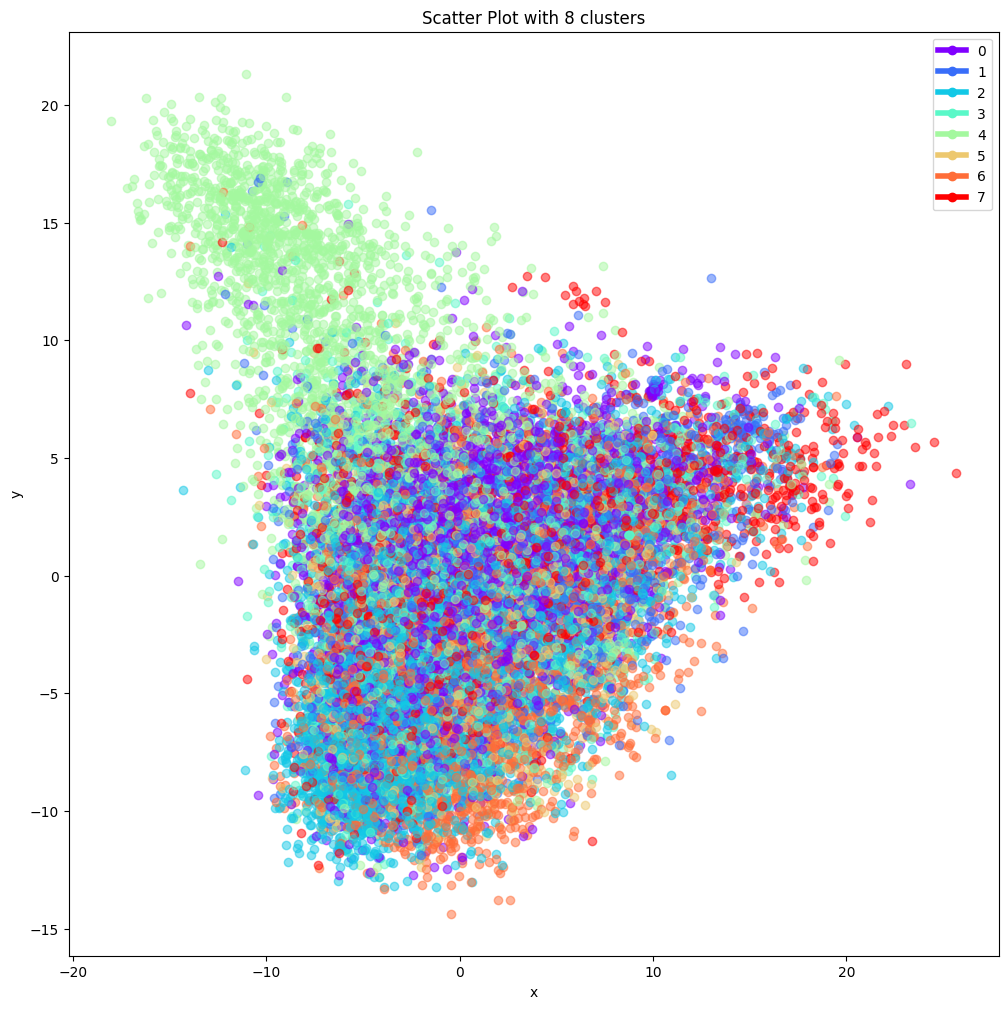

100%|██████████| 20362/20362 [04:56<00:00, 68.75it/s]


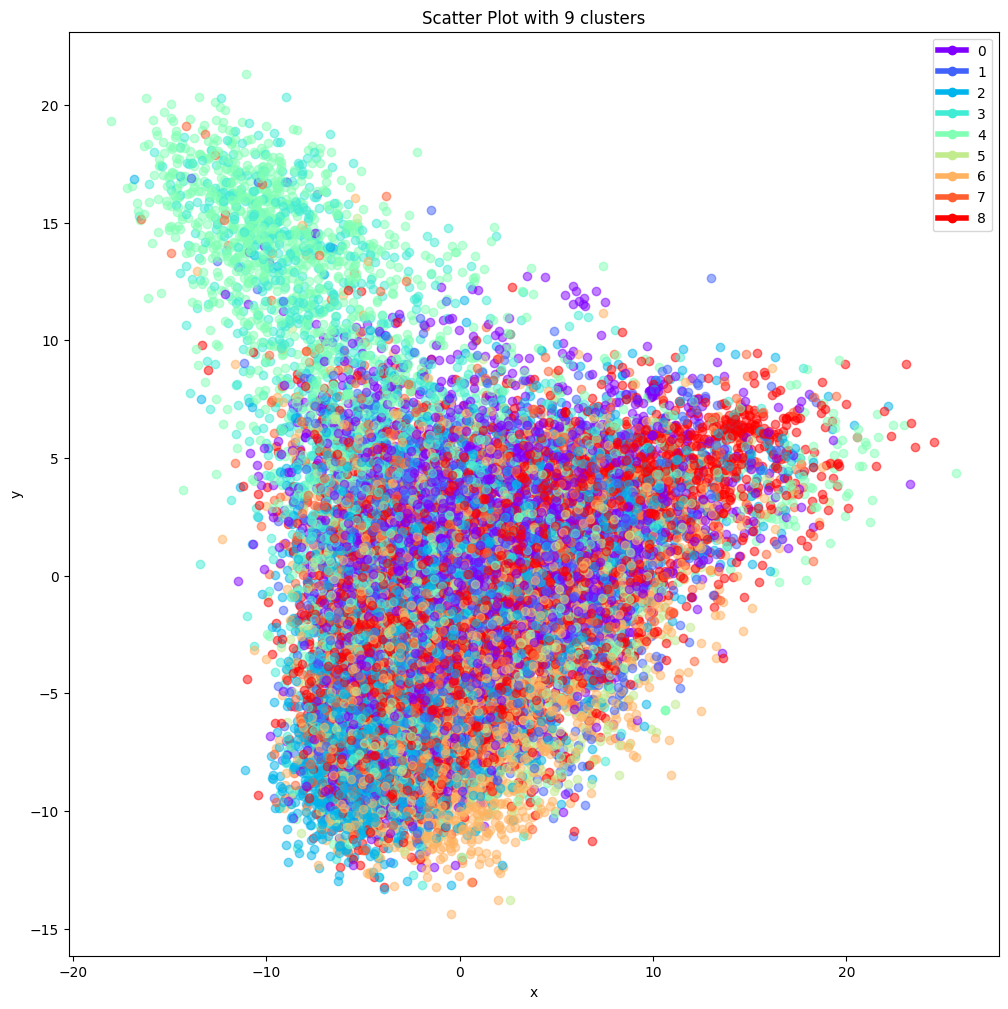

100%|██████████| 20362/20362 [04:29<00:00, 75.67it/s]


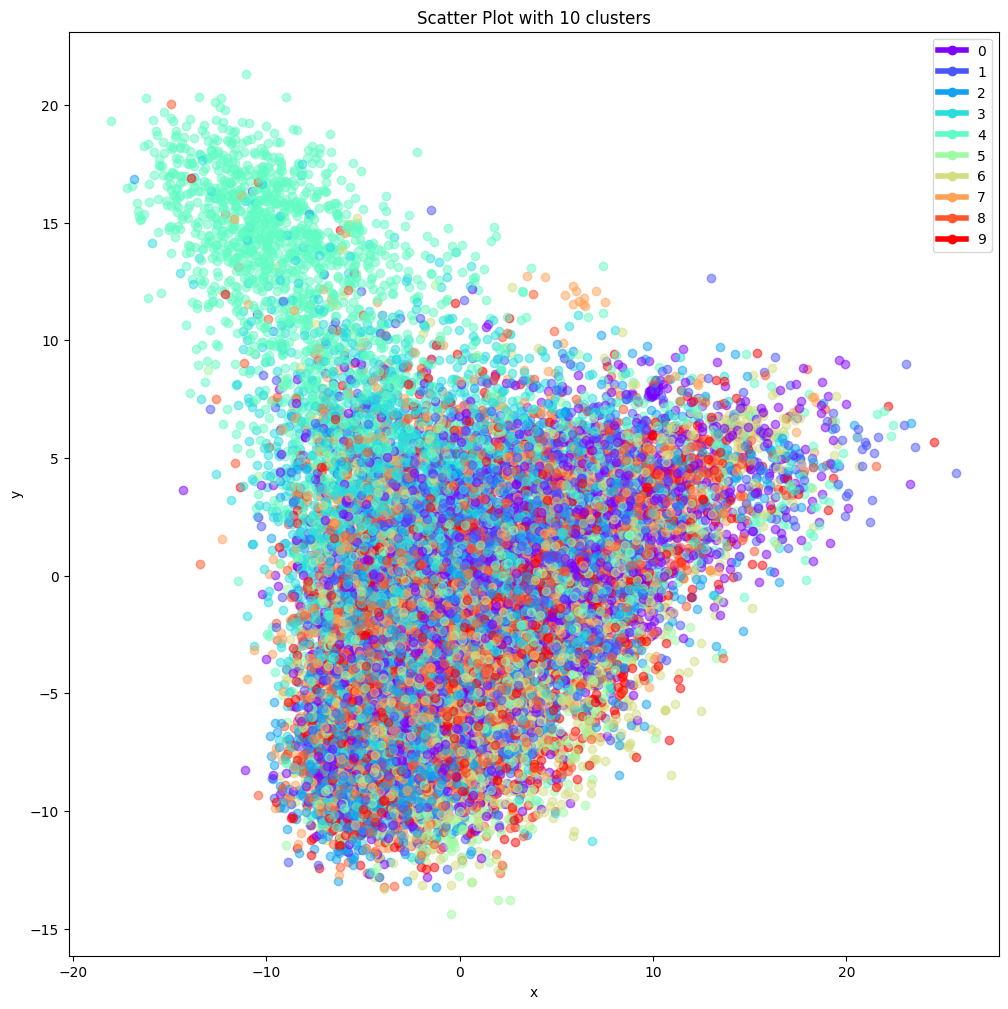

In [54]:
for labels in label_list:
    plt.figure(figsize=(12, 12))
    unique_labels = set(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    label_to_color = {label: color for label, color in zip(unique_labels, colors)}
    
    for i in tqdm.tqdm(range(len(url_dataset))):
        plt.scatter(x[i], y[i], color=label_to_color[labels[i]], alpha=0.5)
        
    # Create a custom legend
    legend_labels = [plt.Line2D([0], [0], color=color, lw=4, marker='o') for color in colors]
    plt.legend(legend_labels, unique_labels)
    
    plt.title(f'Scatter Plot with {len(unique_labels)} clusters')
    plt.xlabel('x')
    plt.ylabel('y')
    
    plt.show()

In [15]:
import spacy
from sklearn.manifold import TSNE
nlp = spacy.load('en_core_web_md') 
eight_clusters_top_words = top_words_list[0]
eight_clusters_top_words

/Users/binglunli/Desktop/Quantcast/QuantcastEnv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{0: ['best',
  'things',
  'travel',
  'reviews',
  'world',
  'visit',
  'game',
  'home',
  'guide',
  'places',
  'family',
  'city',
  'beach',
  'know',
  'dog',
  'attractions'],
 1: ['video',
  'free',
  'photos',
  'single',
  'documents',
  'music',
  'lets',
  'access',
  'place',
  'mediafire',
  'service',
  'use',
  'share',
  'simple',
  'games',
  'game',
  'tickets'],
 2: ['best',
  'page',
  'april',
  'sale',
  'people',
  'music',
  'free',
  'tv',
  'year',
  'county',
  'years',
  'cars',
  'state',
  'local',
  'used'],
 3: ['weather',
  'free',
  'best',
  'business',
  'quality',
  'highest',
  'moon',
  'learning',
  'day',
  'platform',
  'baby',
  'awesome',
  'brands',
  'forecast',
  'courses',
  'does'],
 4: ['recipe',
  'easy',
  'make',
  'chicken',
  'food',
  'recipes',
  'best',
  'delicious',
  'cake',
  'healthy',
  'perfect',
  'cheese',
  'cream',
  'just',
  'dinner',
  'simple',
  'free',
  'chocolate',
  'good'],
 5: ['stock',
  'world',
  'lat

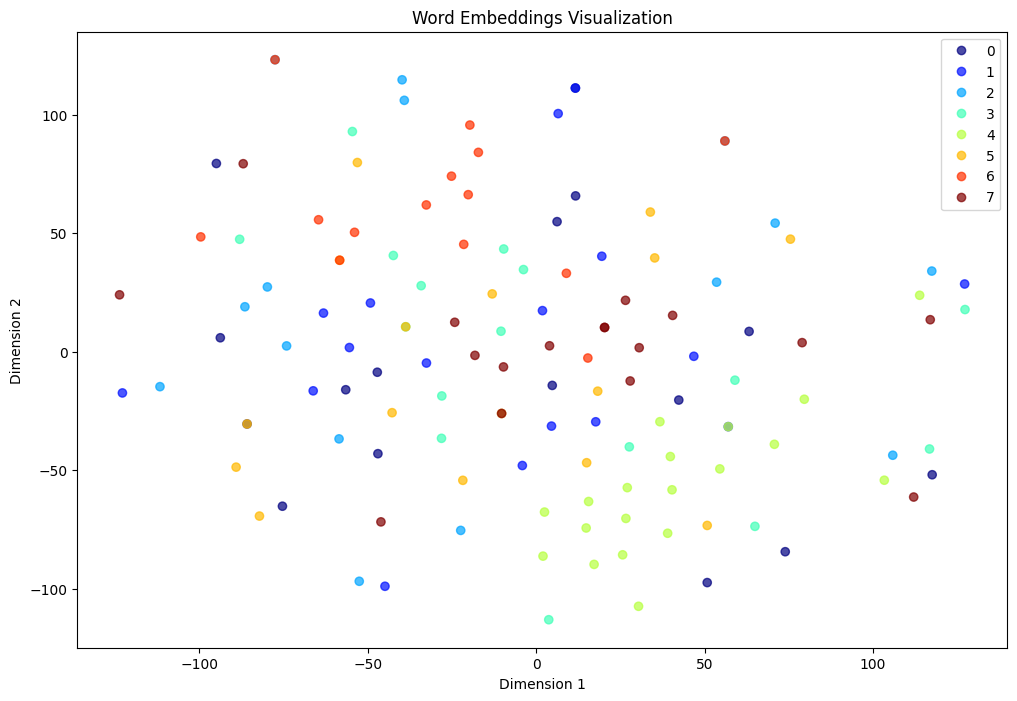

In [19]:
embeddings = []
colors = []
for group_idx, words in eight_clusters_top_words.items():
    for word in words:
        token = nlp(word)
        if token.has_vector:  # Check if the word has a vector representation
            embeddings.append(token.vector)
            colors.append(group_idx)

# Reduce dimensions to 2 using t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(np.array(embeddings))

# Plotting
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, cmap="jet", alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=eight_clusters_top_words.keys())
plt.title("Word Embeddings Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()